In [34]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import extract as xfn

# Define paths
#----------------------------------------------------------------------
Fcode = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
Fdata = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
Fdoc = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/Data2process/Project/' 
F10t2 = '/Volumes/Dominic 10tb2/Data2process/Project/'
Ftm = '/Volumes/Dominic Time Machine/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'

%load_ext autoreload
sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

# Extract suite2p data

In [36]:
# Define fish folder
#------------------------------
experiment = 'BLNDEV-WILDTYPE'
save_folder = 'BLNDEV-WILDTYPE'
disk = F10t
date_list = adfn.return_files(disk, experiment, '**')
date_list

['210329-WILDTYPE']

In [37]:
#Extract all active cells from suite2p plane data and save in Fsave
#--------------------------------------------------------------------
for x,date in enumerate(date_list): #loop through all files across different dates
    fish_list = adfn.return_files(disk + experiment + os.sep, date, '**')
    for fish in fish_list: #loop through each fish in each folder
        Fs2p = disk + experiment + os.sep + date + os.sep + fish + os.sep + 'suite2p'
        Fish  = xfn.fish_load(Fs2p, Fdata + save_folder, fish, experiment, date) 
    print('Processed folder' + str(x+1) + ' of ' + str(len(date_list)) )

Found 10 planes
Found 21388 cells
Saved F01-BLNGR-WILDTYPE-2photon-4dpf-gc6s-20%-sess-01-run-01 in BLNDEV-WILDTYPE
Found 10 planes
Found 32135 cells
Saved F02-BLNGR-WILDTYPE-2photon-4dpf-gc6s-20%-sess-01-run-01 in BLNDEV-WILDTYPE
Found 10 planes
Found 20387 cells
Saved F03-BLNGR-WILDTYPE-2photon-4dpf-gc6s-20%-sess-01-run-01 in BLNDEV-WILDTYPE
Processed folder1 of 1


# Filter non-cells

In [164]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'BLNDEV-WILDTYPE'
coord_list = adfn.return_files(Fdata, experiment, '*allcoord.npy')
trace_list = adfn.return_files(Fdata, experiment, '*alltrace.npy')
coord_list, trace_list

(['BLNDEV-WILDTYPE-01_2photon_sess-01-4dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-01_2photon_sess-01-5dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-01_2photon_sess-01-6dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-01_2photon_sess-01-7dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-01_2photon_sess-01-8dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-02_2photon_sess-01-4dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-02_2photon_sess-01-5dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-02_2photon_sess-01-6dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-03_2photon_sess-01-4dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-03_2photon_sess-01-6dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-04_2photon_sess-01-4dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-04_2photon_sess-01-5dpf_BLNGR_run-01_allcoord.npy',
  'BLNDEV-WILDTYPE-04_2photon_sess-01-6dpf_BLNGR_run-01_allcoord.npy',
  'BLN

In [ ]:
# Loop through and threshold
#------------------------------

thresh = 1.01 #1.01 
highcut = 500 #high freq cutoff
lowcut = 0 #low freq cutoff
window = 9 #window size for max-min calculation, 9 or 41
save = 'yes' #yes to save

for x in range(len(coord_list)): 
    
    Fish = {} #Define dict
    
    Ftrace, Fcoord = trace_list[x], coord_list[x]
    
    # Create dict - Fish
    #---------------------------------------------------------------------------
    #Fish = {'Trace':np.load(Ftrace), 'Coord': np.load(Fcoord)}
    
    #Use if cutting off first 5 mins of recording
    Fish = {'Trace':np.load(Ftrace)[:,819:], 'Coord': np.load(Fcoord)}

    # Apply bandpass filter normalise and choose n cells to plot, plot raw + filt
    #-----------------------------------------------------------------------------
    Ffilt, Fnorm = xfn.fish_filter(Fish['Trace'], highcut, lowcut)
    Fish.update({'Filt':Ffilt, 'Norm':Fnorm})
    
    # Define size of sliding window in frames to calculate max of mins
    #---------------------------------------------------------------------------
    Fmxmn = xfn.fish_max_min(Fish['Norm'], window) 
    Fish.update({'Maxmin':Fmxmn})
    
    #Apply threshold
    ffin = xfn.fish_thresh(Fdata + experiment, Fcoord, Fish['Trace'], Fish['Coord'], Fish['Maxmin'], thresh, save)
        
    print('Processed ' + str(x+1) + ' of ' + str(len(coord_list)) )

# Back up data

In [40]:
# Define fish folder
#------------------------------
experiment = 'BLNDEV-WILDTYPE'
disk = F10t #location of files to backup
backup = '/Volumes/Dominic 10tb2/' #destination to back up
add = 'yes' #add the day to the filing name
date_list = adfn.return_files(disk, experiment, '**')
date_list

['210329-WILDTYPE']

In [46]:
#Extract all active cells from suite2p plane data and save in Fsave
#--------------------------------------------------------------------
for x,date in enumerate(date_list): #loop through all files across different dates
    fish_list = adfn.return_files(disk + experiment + os.sep, date, '**')
    for fish in fish_list: #loop through each fish in each folder
        Fs2p = disk + experiment + os.sep + date + os.sep + fish + os.sep + 'suite2p'
        
        #Backup regtiffs, ops and stat files - makesubdir yes only for each new fish
        #dir_mode = new, add_condition, add_day
        #---------------------------------------------------------------------------
        Backup  = xfn.fish_backup(Fs2p, backup, experiment, fish, date, add_day = add, dir_mode = 'new')
        
    print('Processed folder ' + str(x+1) + ' of ' + str(len(date_list)) )

Processed folder 1 of 1


# Normalise traces

In [49]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'BLNDEV-WILDTYPE'
rt_list = adfn.return_files(Fdata, experiment, '*realtrace.npy')
rt_list

['BLNDEV-WILDTYPE-01_2photon_sess-01-4dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-5dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-6dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-7dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-01_2photon_sess-01-8dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-4dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-5dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-02_2photon_sess-01-6dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-03_2photon_sess-01-4dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-03_2photon_sess-01-6dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-4dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-5dpf_BLNGR_run-01_realtrace.npy',
 'BLNDEV-WILDTYPE-04_2photon_sess-01-6dpf_BLNGR_run-01_realtrace.npy',
 'BLND

In [12]:
for e in range(len(rt_list)):
    name = rt_list[e]
    mat = np.load(rt_list[e])
    dff_mat =  xfn.deltaff(mat, 0.05)
    np.save(Fdata + experiment + os.sep + name[:name.find('run')+6] + '_' +'deltaff.npy', dff_mat)  
    print('Done ' + name)

Done BLNDEV-WILDTYPE-01_2photon_sess-01-4dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-01_2photon_sess-01-5dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-01_2photon_sess-01-6dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-01_2photon_sess-01-7dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-01_2photon_sess-01-8dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-02_2photon_sess-01-4dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-02_2photon_sess-01-5dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-02_2photon_sess-01-6dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-03_2photon_sess-01-4dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-03_2photon_sess-01-6dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-04_2photon_sess-01-4dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-04_2photon_sess-01-5dpf_BLNGR_run-01_realtrace.npy
Done BLNDEV-WILDTYPE-04_2photon_sess-01-6dpf_BLNGR_run-01_realtr

# Binarise traces
* replace BCL with Oasis?


In [72]:
wdt = 0.59 #spiking probability = 0.59
lamb = 0.5 #calcium decay = 0.5
varB = 0.001 #baseline variance = 0.001
varC = 1 #calcium variance = 1
Cmean = 0.2 #mean calcium = 0.2
frequency = 2.7 #frequency = 2.7
gausfilt = 0.6 #gausfilt = 0.6
mode = 'save'

for i in range(len(rt_list)):
    name = rt_list[i][:rt_list[i].find('run')+6]
    data = np.load(rt_list[i])
    c, sks, B = xfn.bcl_function_parameters(wdt, Fdata, experiment, name, data ,lamb, varB, varC, Cmean, frequency, gausfilt, mode )
    print('Done ' + name)

Done BLNDEV-WILDTYPE-01_2photon_sess-01-4dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-01_2photon_sess-01-5dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-01_2photon_sess-01-6dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-01_2photon_sess-01-7dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-01_2photon_sess-01-8dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-02_2photon_sess-01-4dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-02_2photon_sess-01-5dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-02_2photon_sess-01-6dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-03_2photon_sess-01-4dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-03_2photon_sess-01-6dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-04_2photon_sess-01-4dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-04_2photon_sess-01-5dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-04_2photon_sess-01-6dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-04_2photon_sess-01-7dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-04_2photon_sess-01-8dpf_BLNGR_run-01
Done BLNDEV-WILDTYPE-05_2photon_sess-01-4dpf_BLNGR_run-01
Done BLNDEV-WI

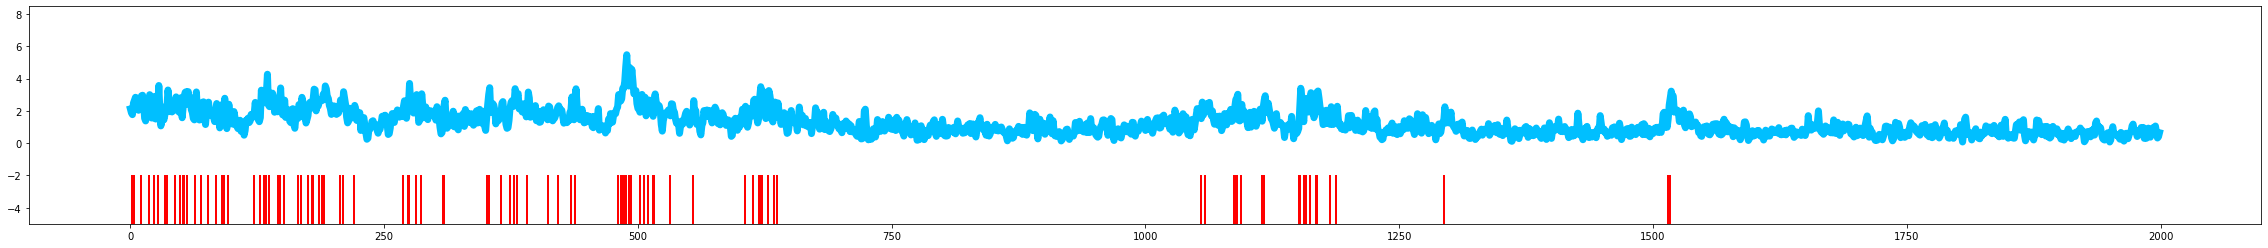

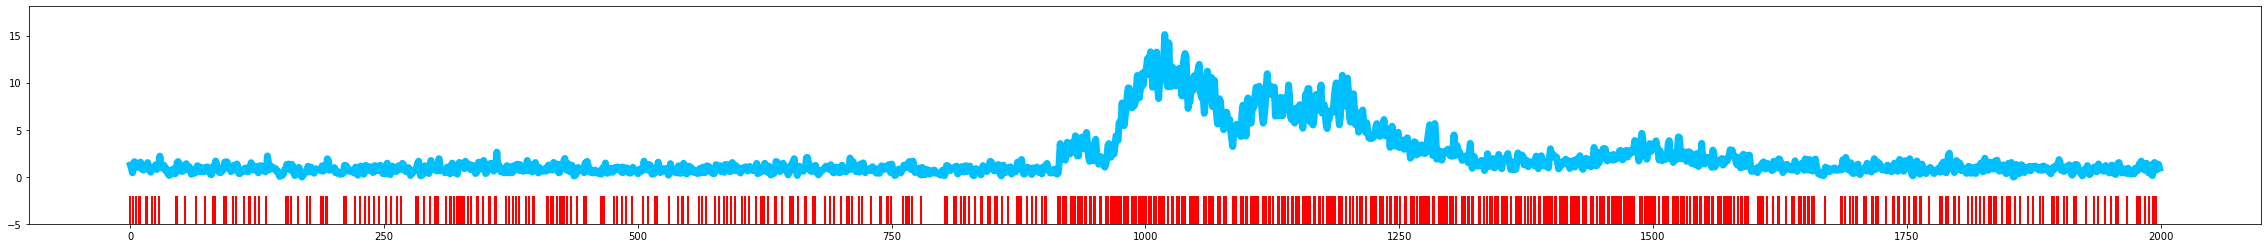

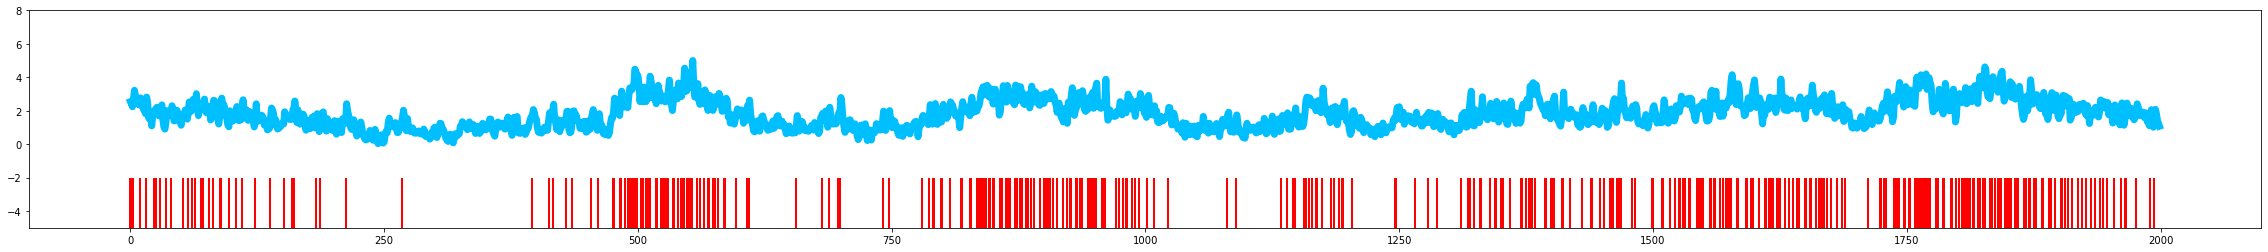

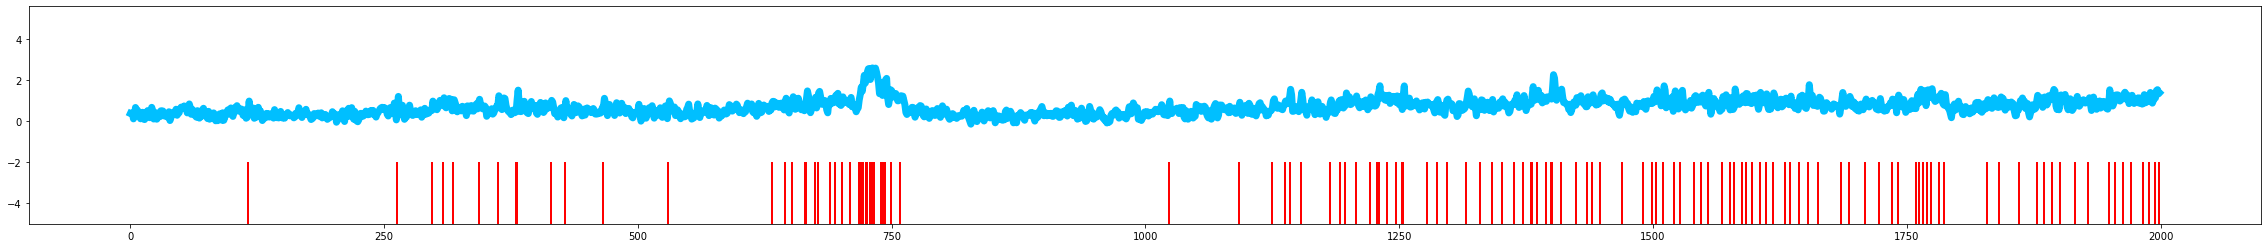

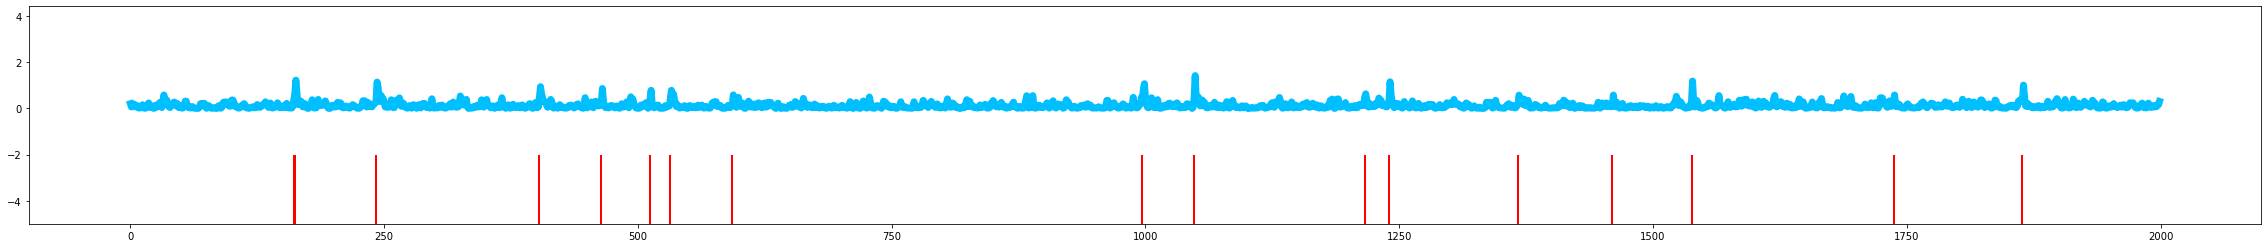

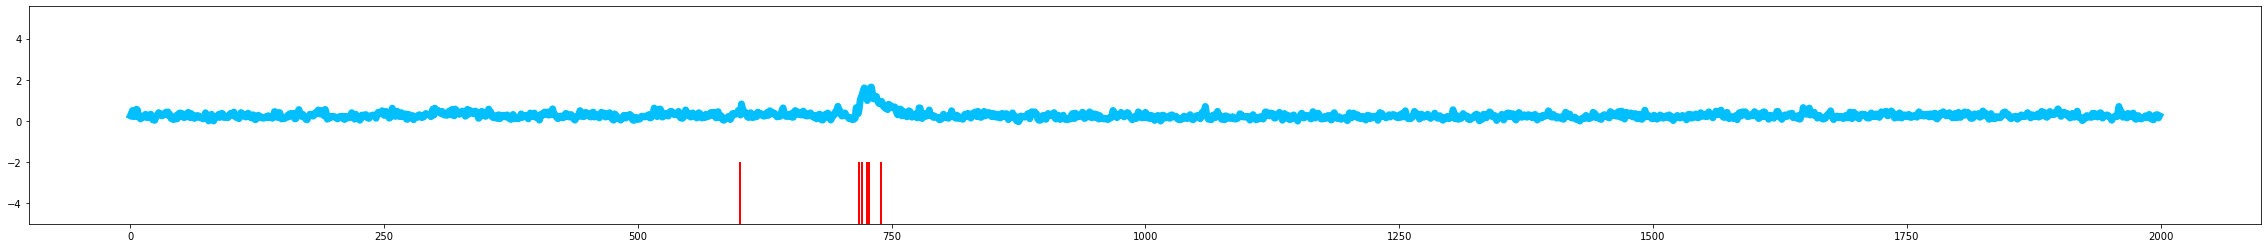

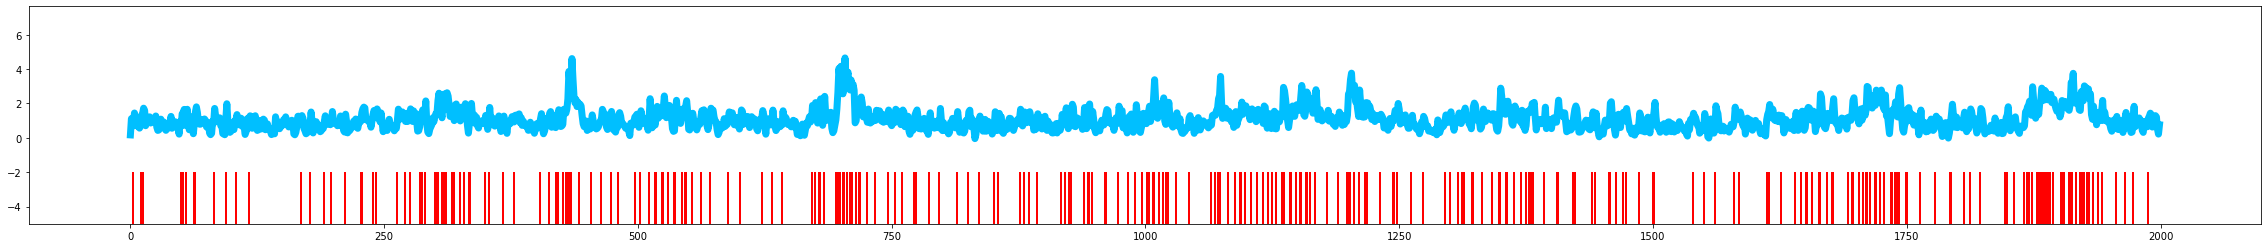

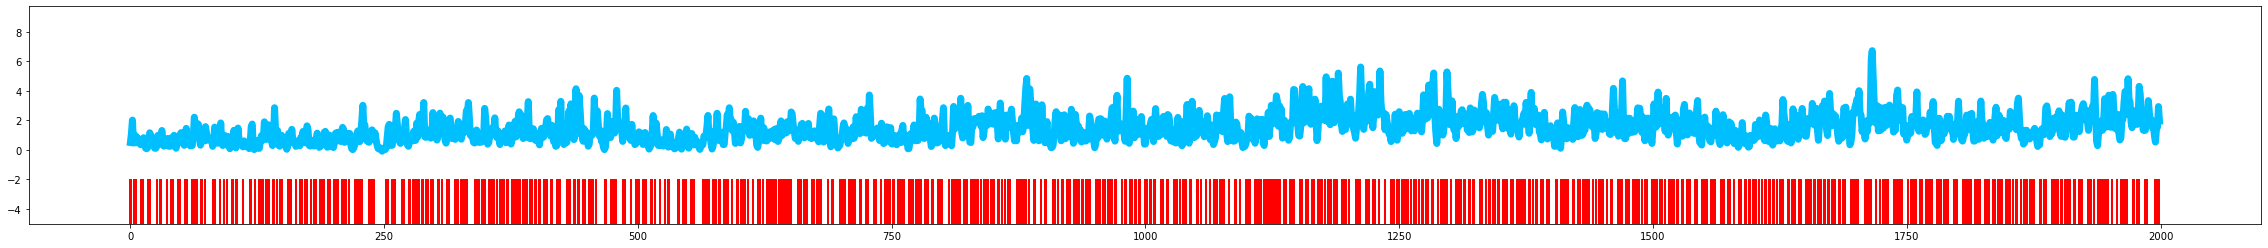

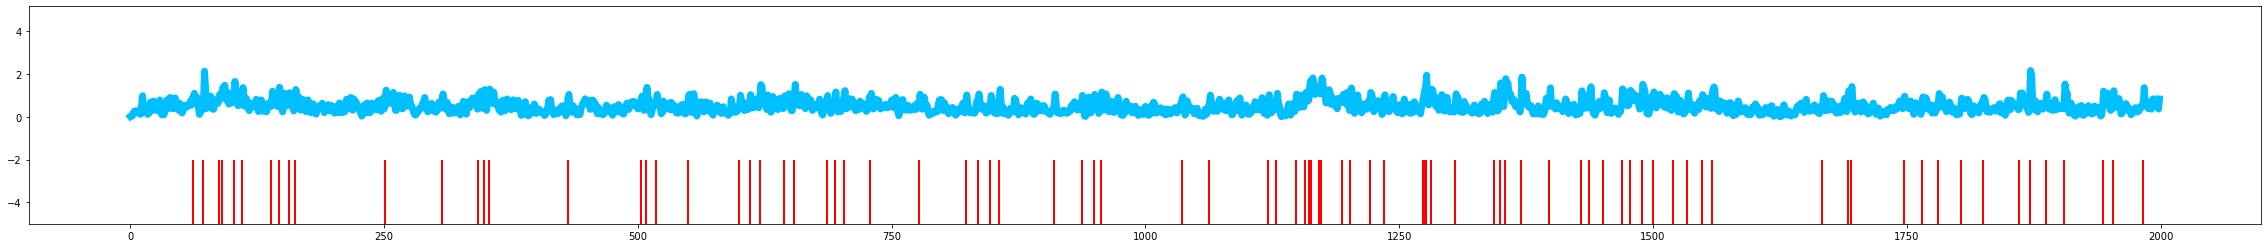

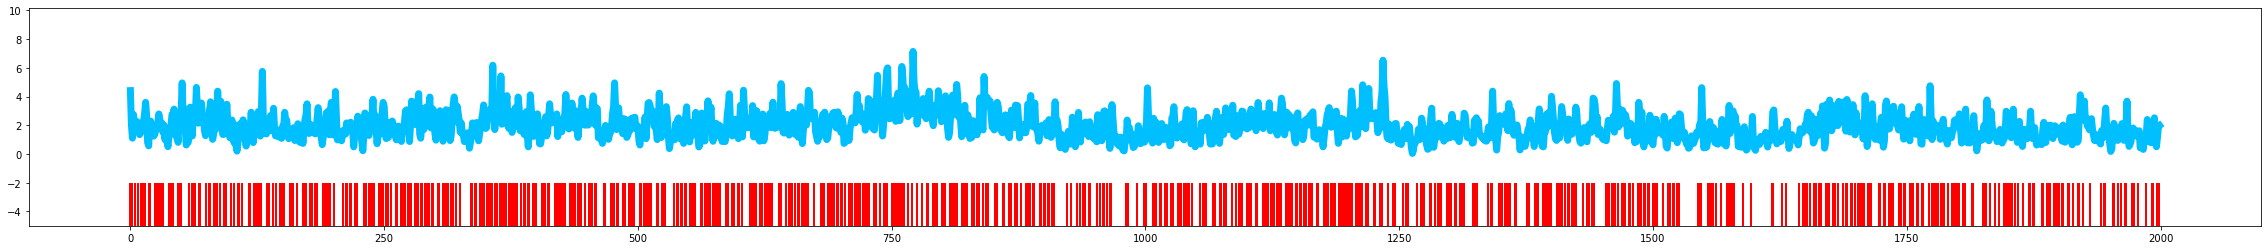

In [89]:
%autoreload

wdt = 0.59 #spiking probability = 0.59
lamb = 0.5 #calcium decay = 0.5
varB = 0.001 #baseline variance = 0.001
varC = 1 #calcium variance = 1
Cmean = 0.2 #mean calcium = 0.2
frequency = 2.7 #frequency = 2.7
gausfilt = 0.6 #gausfilt = 0.6
mode = 'see'

i = 2
name = rt_list[i][:rt_list[i].find('run')+6]
data = np.load(rt_list[i])
xfn.bcl_function_parameters(wdt, Fdata, experiment, name, data ,lamb, varB, varC, Cmean, frequency, gausfilt, mode )